In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import itertools
import numpy as np
import infomap
from infomap import Infomap
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
from utils import *

# Worm cortex Graph community detection. 
### The connectome of the anterior section of the hermaphrodite c. elegans. The source of this data is from the second listed dataset at wormatlas. 
#####  https://neurodata.io/project/connectomes/
##### https://github.com/ericmjonas/circuitdata/tree/master/celegans_herm


2478 edges and 279 nodes
68


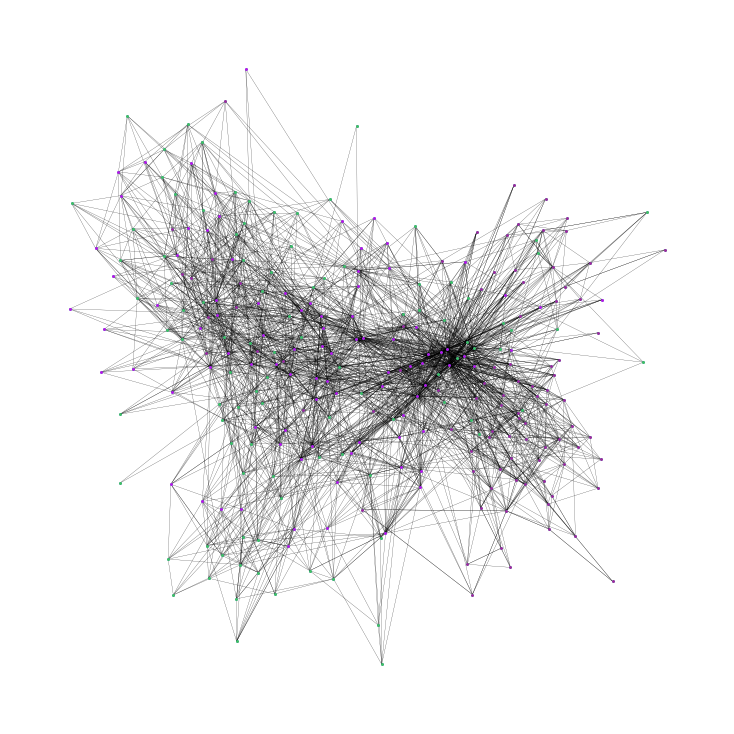

In [15]:
# Read in graph
G = nx.read_graphml('../Datasets/c.elegans.herm_pharynx_1.graphml')
G = G.to_undirected()

print(f"{G.number_of_edges()} edges and {G.number_of_nodes()} nodes")

cell_name_attr = nx.get_node_attributes(G,'cell_name').values()
role_attr = nx.get_node_attributes(G,'role').values()
cell_class_attr = nx.get_node_attributes(G,'cell_class').values()
neuro_attr = nx.get_node_attributes(G,'neurotransmitters').values()
soma_attr = nx.get_node_attributes(G,'soma_pos').values()


# create pandas dataframe for analysis of metadata
df = pd.DataFrame({'cell name':cell_name_attr,'role':role_attr, 'cell class':cell_class_attr,'neurtransmitters':neuro_attr,'soma_pos':soma_attr})


print(len(df["soma_pos"].value_counts()))
# role has 3 classes and neurtransmitters has 7. These could relate to communities.
# Seperate nodes into lists for each role
roles = [[] for _ in range(len(df["role"].value_counts()))]

for key,value in nx.get_node_attributes(G,'role').items():
    if value == 'NA':
        roles[0].append(key)
    if value == 'S':
        roles[1].append(key)
    if value == 'M':
        roles[2].append(key)

# Color nodes based on their roles
presentBioCommunities(G,roles) 

NA          161
Ach          74
GABA         26
DA            8
5-HT          4
Ach,5-HT      4
GLU           2
Name: neurtransmitters, dtype: int64


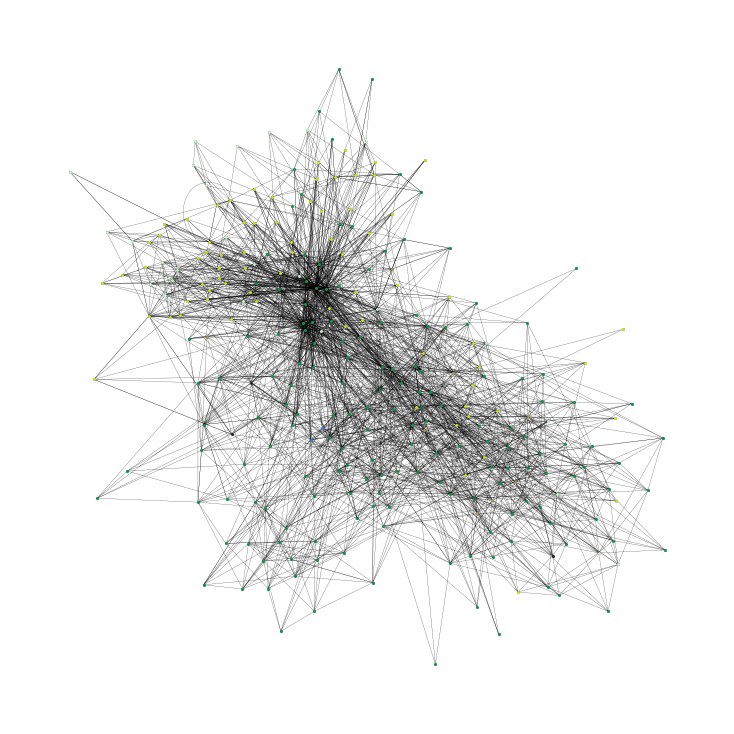

In [10]:
neurotransmitters_list = [[] for _ in range(len(df["neurtransmitters"].value_counts()))]

print(df["neurtransmitters"].value_counts())

for key,value in nx.get_node_attributes(G,'neurotransmitters').items():

    if value == 'NA':
        neurotransmitters_list[0].append(key)
    if value == 'Ach':
        neurotransmitters_list[1].append(key)
    if value == 'GABA':
        neurotransmitters_list[2].append(key)
    if value == 'DA':
        neurotransmitters_list[3].append(key)
    if value == '5-HT':
        neurotransmitters_list[4].append(key)
    if value == 'Ach,5-HT':
        neurotransmitters_list[5].append(key)
    if value == 'GLU':
        neurotransmitters_list[6].append(key)

# Color nodes based on their roles
presentBioCommunities(G,neurotransmitters_list) 

# Girvan Newman 
##### Invesitigate how modularity changes as more disconections are made and more communities are found

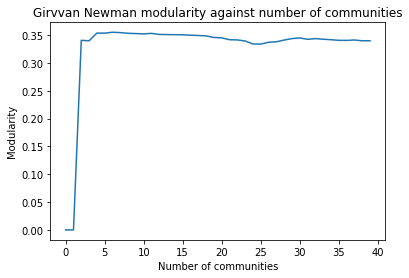

CPU times: user 3min 14s, sys: 81.8 ms, total: 3min 14s
Wall time: 3min 14s


In [4]:
%%time
# Algorithm 1. Girvan Newman 
partition_girvan_newman = girvan_newman(G)
k = 40 # Check 39 partitions

mod_list = []
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)
    # Use modularity to check partition
    GN_mod = nx_comm.modularity(G,partitions)
    mod_list.append(GN_mod)

# plot partitions with k to optimize modularity
plt.plot(mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Girvvan Newman modularity against number of communities")
plt.show()

##### Set stopping point at 5 communities in order to maximize modularity


5 communities detected
The modularity is 0.34


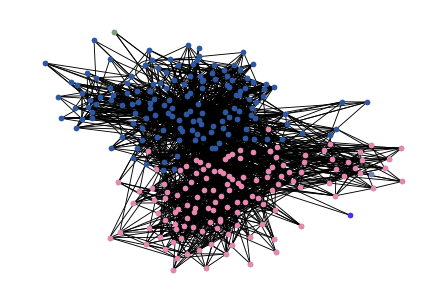

CPU times: user 2min 28s, sys: 22.4 ms, total: 2min 28s
Wall time: 2min 28s


In [13]:
%%time 
partition_girvan_newman = girvan_newman(G)
k=4 # if we have apriori knowledge of 15 groudn truth communities:
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)

GN_mod = nx_comm.modularity(G,partitions)
print(f"{len(partitions)} communities detected")
print(f"The modularity is {GN_mod:.3}")
presentBioCommunities(G,partitions)

# Infomap
#####  https://github.com/mapequation/infomap

(['n54', 'n53', 'n56', 'n55', 'n150', 'n149', 'n58', 'n109', 'n57', 'n157', 'n110', 'n66', 'n156', 'n70', 'n160', 'n27', 'n67', 'n141', 'n0', 'n140', 'n154', 'n155', 'n91', 'n111', 'n71', 'n6', 'n171', 'n152', 'n172', 'n205', 'n34', 'n148', 'n36', 'n208', 'n138', 'n108', 'n23', 'n63', 'n127', 'n151', 'n126', 'n100', 'n81', 'n80', 'n139', 'n35', 'n93', 'n207', 'n162', 'n99', 'n255', 'n22', 'n24', 'n37', 'n163', 'n92', 'n246'], ['n60', 'n165', 'n164', 'n175', 'n166', 'n181', 'n167', 'n185', 'n178', 'n129', 'n188', 'n128', 'n83', 'n169', 'n184', 'n168', 'n2', 'n189', 'n179', 'n223', 'n186', 'n224', 'n196', 'n197', 'n221', 'n82', 'n187', 'n124', 'n85', 'n115', 'n84', 'n117', 'n121', 'n120', 'n133', 'n114', 'n193', 'n232', 'n192', 'n118', 'n119', 'n236', 'n125', 'n116', 'n183', 'n131', 'n235', 'n122', 'n191', 'n132', 'n130', 'n182', 'n198', 'n230', 'n123', 'n190', 'n234', 'n229', 'n215', 'n228', 'n233', 'n226', 'n199', 'n227', 'n216', 'n225', 'n214', 'n212', 'n211', 'n209', 'n213', 'n210'],

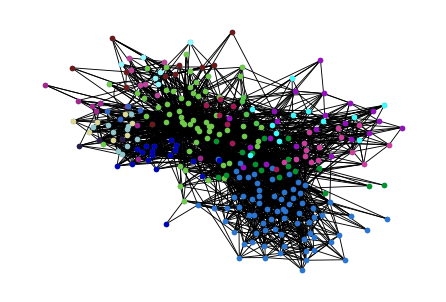

CPU times: user 656 ms, sys: 164 ms, total: 820 ms
Wall time: 353 ms


In [6]:
%%time
# Algorithm 2. k infomap
im = Infomap(silent=True)
im.add_networkx_graph(G)
im.run()

partition = [[] for _ in range(im.num_top_modules)]
for node in im.tree:
    if node.is_leaf:
        partition[node.module_id-1].append("n"+ str(node.node_id))

partitions = tuple(partition)

info_mod = nx_comm.modularity(G,partitions)
print(f"{len(partitions)} communities detected")
print(f"The modularity is {info_mod:.3}")

presentBioCommunities(G,partitions)

# Spectral Clustering

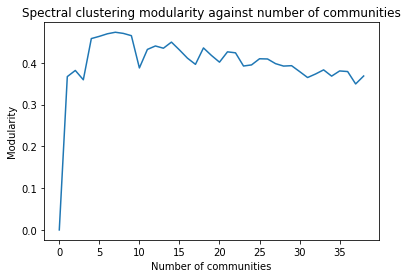

CPU times: user 2min 6s, sys: 1min 9s, total: 3min 15s
Wall time: 34.4 s


In [7]:
%%time
# Algorithm 3. Spectral clustering
# Get adjacency-matrix as numpy-array
sc_mod_list = []
for k in range(1,40):
    adj_mat = nx.to_numpy_matrix(G)
    # Cluster
    sc = SpectralClustering(k, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    partition_labels = sc.labels_.tolist()
    # Turn back into partition data structure ([],[],[]...)
    # position in list is node number value is community id

    partition = [[] for _ in range(max(partition_labels)+1)]
    for idx,c in enumerate(partition_labels):
        partition[c].append("n"+ str(idx))

    sc_mod = nx_comm.modularity(G,tuple(partition))
    sc_mod_list.append(sc_mod)

# Plot modularity for increasing community number
plt.plot(sc_mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Spectral clustering modularity against number of communities")
plt.show()

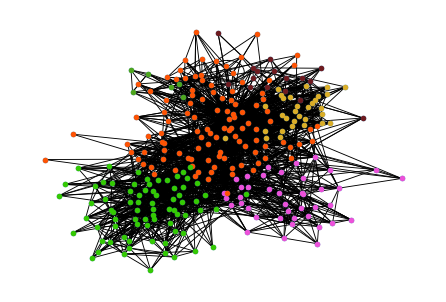

6 communities detected
The modularity is 0.463
CPU times: user 1.27 s, sys: 344 ms, total: 1.62 s
Wall time: 676 ms


In [11]:
%%time
k=6 #for maximum modularity
# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G)
# Cluster
sc = SpectralClustering(k, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

partition_labels = sc.labels_.tolist()
# Turn back into partition data structure ([],[],[]...)
# position in list is node number value is community id

partition = [[] for _ in range(max(partition_labels)+1)]
for idx,c in enumerate(partition_labels):
    partition[c].append("n"+ str(idx))

# Need to decide when to stop removing edges.
presentBioCommunities(G,partition)

sc_mod = nx_comm.modularity(G,tuple(partition))
print(f"{len(partition)} communities detected")
print(f"The modularity is {sc_mod:.3}")

# Analysis

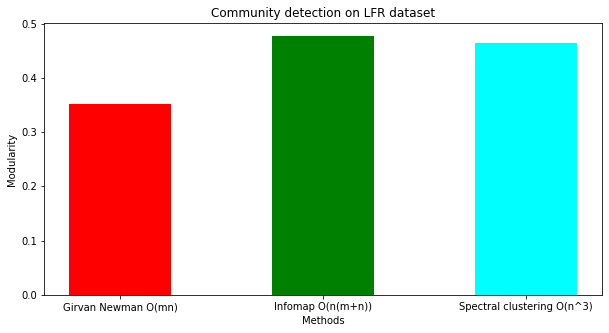

In [12]:
# Compare methods
data = {'Girvan Newman O(mn)':GN_mod, 'Infomap O(n(m+n))':info_mod,
        'Spectral clustering O(n^3)':sc_mod}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("Modularity")
plt.title("Community detection on LFR dataset")
plt.show()

In [11]:
# Measure overlap of found communities with node class metadata
# measure overlap of clusters values with some metric to se>>> from sklearn.metrics.cluster import normalized_mutual_info_score

# trat the node metadata as clustering nodes into communities..
# role has 3 classes and neurtransmitters has 7. These could relate to communities.

# neurotransmitters_list
# roles


n = G.number_of_nodes()
ground_truth_communites_vector = NMI_reshape_cortical(neurotransmitters_list,n)
k=5 #From the maximum of modularity asa function of community number. 

communities = CommunityDetectionAlgorithms.girvan_newman_calc(G,k)
communities_vector = NMI_reshape_cortical(communities,n)
gn_NMI = normalized_mutual_info_score(ground_truth_communites_vector,communities_vector)

# ------- Infomap -------
print("Infomap")
communities = CommunityDetectionAlgorithms.infomap_calc(G)
communities_vector = NMI_reshape(communities,n)
im_NMI = normalized_mutual_info_score(ground_truth_communites_vector,communities_vector)

# ------- Spcetral Clustering -------
print("Spectral clustering")
communities = CommunityDetectionAlgorithms.spectral_cluster_calc(G,k)
communities_vector = NMI_reshape(communities,n)
sc_NMI = normalized_mutual_info_score(ground_truth_communites_vector,communities_vector)


0
1
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
27
39
40
41
42
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
71
72
73
74
75
76
77
78
79
80
81
108
110
111
112
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
139
140
141
142
143
144
145
146
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
177
178
179
180
181
183
184
185
186
187
188
189
190
195
196
197
198
199
200
210
211
212
213
214
215
216
217
226
227
228
229
230
231
232
233
234
235
236
237
25
26
28
29
30
31
32
33
34
35
36
37
38
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
147
148
201
202
203
204
205
206
207
208
209
218
219
220
221
222
223
224
225
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
70
102
103
104
105
106
107
109
182
191
192
193
194
266
267
268
269
270
271
272
273
274
275
276
277
278
2
3
82
83
84
85
137
138
4
174
175
176
113
114
264
265


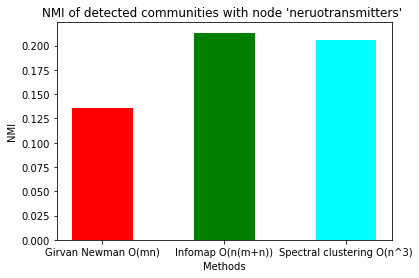

In [12]:
# Compare NMI 

data = {'Girvan Newman O(mn)':gn_NMI, 'Infomap O(n(m+n))':im_NMI,
        'Spectral clustering O(n^3)':sc_NMI}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(facecolor=(1, 1, 1))

# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("NMI")
plt.title("NMI of detected communities with node 'neruotransmitters' ")
plt.show()
fig.savefig('../figures/cortex_community_neurotransmitters_overlap')